## 1. Install and import libraries

In [1]:
pd.options.mode.chained_assignment = None

NameError: name 'pd' is not defined

In [2]:
# Basic
import numpy as np
import pandas as pd
from functools import partial

# Scikit-Learn
from sklearn.model_selection import \
    (cross_validate,
     train_test_split,
     KFold,
     ShuffleSplit)

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.base import clone

# Statsmodels
import statsmodels.api as sm

# Matplotlib
import matplotlib.pyplot as plt

## 2. Test the test error rates thorugh the validation Set Approach

In this section, we explore the application of the validation set approach to estimate test error rates incurred when fitting various linear models to the ``auto`` dataset. This dataset comprises data on gas mileage, horsepower, and other specifications for 392 vehicles. 

We start:

1. Loading the ``auto`` dataset
1. Dropping unnecesary columns
2. Splitting into general training and test sets.

In [3]:
auto = pd.read_csv('https://raw.githubusercontent.com/qlabpucp/datasets/main/datasets/auto.csv')
auto = auto.drop(columns=['Unnamed: 0', 'name'])

We then:

1. Split this dataset into general training and test sets. We set a random seed to ensure reproductibility
2. Further split these subsets to isolate specific features and target variables. For the training set (``auto_train``), we extract 'horsepower' as the feature (``x_train``) and 'mpg' (miles per gallon) as the target variable (y_train). We did the same for validation set.

In [5]:
auto_train, auto_valid = train_test_split(auto, test_size=196, random_state=0)

x_train = auto_train[['horsepower']]
y_train = auto_train[['mpg']]

x_valid = auto_valid[['horsepower']]
y_valid = auto_valid[['mpg']]

Next, we proceed with the model fitting and evaluation:

1. Initialize and Train the Model:

- We instantiate a LinearRegression model from the ``scikit-learn`` library.
- The model is then trained using the fit method on the training data (x_train for features and y_train for the target variable).

2. Model Prediction and Evaluation:

- We use the trained model to predict the mpg values on the validation set (x_valid) and store these predictions in valid_pred.
- The performance of the model is evaluated by calculating the mean squared error (MSE) between the actual mpg values (y_valid) and the predicted values (valid_pred). This is achieved using: ``np.mean((y_valid - valid_pred)**2)``.

Note: Unless specified otherwise, scikit-learn's LinearRegression model automatically includes an intercept term in its calculations by default.

In [6]:
model = LinearRegression()
model.fit(x_train, y_train)


LinearRegression()

In [8]:
valid_pred = model.predict(x_valid)
np.mean((y_valid - valid_pred)**2)

mpg    23.616617
dtype: float64

Now we define a function to automatize the estimation for the MSE

In [9]:
def evalMSE(X_train, y_train, X_test, y_test):

    """
    Objective:
        - To compute the Mean Squared Error (MSE) of a 
          linear regression model on test data.

    Input:

        - X_train:  Training feature dataset.
        - y_train:  Training target dataset.
        - X_test:   Test feature dataset.
        - y_test:   Test target dataset.
    """
    
    model = LinearRegression()
    model.fit(X_train, y_train)
    test_pred = model.predict(X_test)

    return np.mean((y_test - test_pred)**2)

Now we test the validation error for higher degree polynomial regressions. We follo these steps:

1. Initialize MSE Array: Create an array MSE with three elements, initialized to zero.
2. Loop Through Polynomial Degrees (1 to 3):
    - For each degree (1 to 3), transform the 'horsepower' feature of both training (auto_train) and validation (auto_valid) datasets into polynomial features.
    - Extract the 'mpg' values as the target variable (y_train and y_valid) from both datasets.
    - Call the ``evalMSE`` function with the polynomial-transformed training and validation data to calculate the Mean Squared Error.
    - Store the MSE value in the corresponding index of the MSE array.

3. Print the array MSE containing MSE values for polynomial degrees 1, 2, and 3.

In [10]:
MSE = np.zeros(3)
for idx, degree in enumerate(range(1, 4)):
    
    poly = PolynomialFeatures(degree=degree)
    X_train_poly = poly.fit_transform(auto_train[['horsepower']])
    X_valid_poly = poly.fit_transform(auto_valid[['horsepower']])
    
    y_train = auto_train['mpg']
    y_valid = auto_valid['mpg']

    MSE[idx] = evalMSE(X_train_poly, y_train, X_valid_poly, y_valid)

print(MSE)

[23.61661707 18.76303135 18.79694163]


We repeat the procedure using a new random selection. To do this, we redefine the ``auto_train`` and ``auto_valid`` sets by changing the random seed.

In [23]:
auto_train, auto_valid = train_test_split(auto, test_size=196, random_state=2024)

MSE = np.zeros(3)
for idx, degree in enumerate(range(1, 4)):

    poly = PolynomialFeatures(degree=degree)
    X_train_poly = poly.fit_transform(auto_train[['horsepower']])
    X_valid_poly = poly.fit_transform(auto_valid[['horsepower']])
    
    y_train = auto_train['mpg']
    y_valid = auto_valid['mpg']

    MSE[idx] = evalMSE(X_train_poly, y_train, X_valid_poly, y_valid)

print(MSE)

[28.29494496 22.22912321 22.39342695]


## 3. Cross Validation

In this section, we assess the Mean Squared Error (MSE) for various models using three cross-validation methods: Leave-One-Out Cross Validation (LOOCV), K-Fold Cross Validation, and the Validation Set Approach.

We start by calculating the Cross-Validation MSE for a Linear Regression Model focusing on the 'horsepower' feature to predict 'mpg'.

- We use the LOOCV approach by setting the ``cv`` parameter as the same number of observations for the dataset. his ensures each instance is used once as a test set while the remainder forms the training set.

- Then we calculate the average MSE, converting it from negative to positive values as cross_validate returns negative MSE scores for optimization purposes.

In [24]:
hp_model = LinearRegression()

X, Y = pd.DataFrame(auto['horsepower']), auto['mpg']

cv_results = cross_validate(hp_model,
                            X,
                            Y,
                            cv = auto.shape[0],
                            scoring = 'neg_mean_squared_error')

cv_err = abs(np.mean(cv_results['test_score']))
cv_err

24.231513517929233

Now we repeat this procedure for all the Cross-Validation approaches with increasingly complex polynomial fits.

### 3.1. Leave-One-Out Cross Validation (LOOCV) Approach

We conduct a series of polynomial fits using degrees ranging from 1 to 5. We follow these steps to achieve this:

1. Initialization: A vector cv_error is initialized with five elements, each intended to store the cross-validation error for polynomial regressions of different degrees.

2. Iterative Polynomial Fits: The for loop iteratively performs the following steps for polynomial degrees 1 through 5, denoted by the variable ``d``:

3. Generates polynomial features of degree ``d`` from the 'horsepower' feature.
    - Fits a Linear Regression model using these polynomial features.
    - Computes the associated cross-validation error using Leave-One-Out Cross Validation (LOOCV), where ``cv`` is set to the total number of observations.
    - Stores the computed error (converted from negative to positive) in the corresponding element of cv_error.

Our output is the cross-validation MSEs for polynomial models of degrees 1 to 5

In [27]:
M_CV['test_score'].shape

(392,)

In [28]:
auto.shape

(392, 8)

In [29]:
cv_error = np.zeros(5)

H = np.array(auto['horsepower'])
M = LinearRegression()

for i, d in enumerate(range(1,6)):
    poly = PolynomialFeatures(degree=d)
    X_poly = poly.fit_transform(H.reshape(-1, 1))
    M_CV = cross_validate(M, X_poly, Y, cv = auto.shape[0], scoring = 'neg_mean_squared_error')
    cv_error[i] = abs(np.mean(M_CV['test_score']))
cv_error

array([24.23151352, 19.24821312, 19.33498406, 19.42443031, 19.03320629])

Now we can plot the results

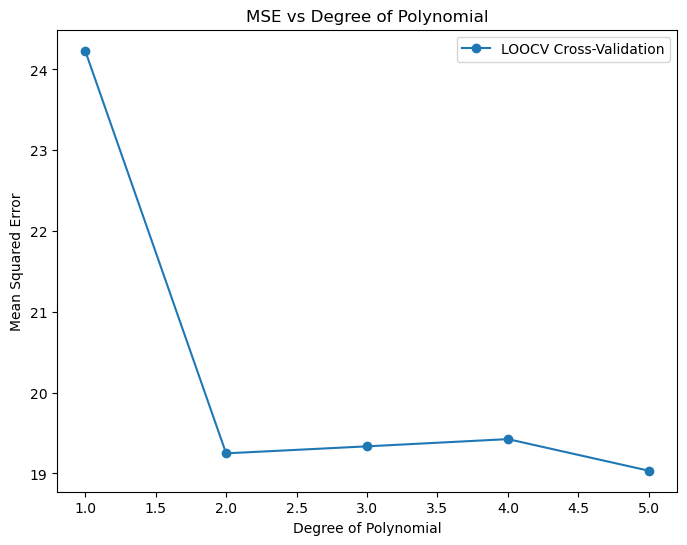

In [30]:
degrees = np.arange(1, 6)

plt.figure(figsize=(8, 6))
plt.plot(degrees, cv_error, label='LOOCV Cross-Validation', marker='o')

plt.xlabel("Degree of Polynomial")
plt.ylabel("Mean Squared Error")
plt.title("MSE vs Degree of Polynomial")
plt.legend()
plt.show()

### 3.2. K-Fold Approach

We now calculate the Mean Squared Error (MSE) for polynomial models using the K-Fold cross-validation approach. This procedure mirrors the previous one with a key difference in the cross-validation setup. We define the K-Fold method using the ``KFold`` function, specifying 10 splits. This approach partitions the dataset into 10 subsets, using each in turn for validation while the rest are used for training. The ``cross_validate`` function computes the MSE for polynomial degrees ranging from 1 to 5, and the results are stored in cv_error.

In [33]:
cv_error = np.zeros(5)

cv = KFold(n_splits=10, shuffle=True, random_state=0)

H = np.array(auto['horsepower'])
M = LinearRegression()
for i, d in enumerate(range(1,6)):
    X = np.power.outer(H, np.arange(d+1))
    M_CV = cross_validate(M, X, Y, cv = cv, scoring = 'neg_mean_squared_error')
    cv_error[i] = abs(np.mean(M_CV['test_score']))
cv_error

array([24.20766449, 19.18533142, 19.27626666, 19.47848402, 19.13719672])

Also we can evaluate the performance of polynomial regression models using 10-fold Cross-Validation, across multiple runs and varying polynomial degrees:

1. Target Variable: Sets Y as the 'mpg' column from the auto dataset.

2. Configuration: Defines num_runs (9) for repeated CV runs and degree_range (10) for the maximum polynomial degree.

3. Error Storage: Initializes cv_errors, a 2D array to store Mean Squared Errors (MSE) for each polynomial degree across different CV runs.

4. Nested Loops for CV:

    - Outer Loop: Iterates over the number of runs (num_runs). In each iteration, a new 10-fold CV object is created with a unique random_state for varied data splits.
    - Inner Loop: Iterates over polynomial degrees from 1 to degree_range. For each degree:
    - Transforms the 'horsepower' feature into polynomial terms using PolynomialFeatures.
    - Performs 10-fold CV on the transformed data using LinearRegression.
    - Calculates and stores the average MSE (converted from negative to positive) for each polynomial degree in cv_errors.
    
5. Result: cv_errors contains the CV MSEs, providing insights into how the model's error varies with polynomial complexity and across different data splits.

In [35]:
Y = auto['mpg']

# Number of runs and polynomial degree range
num_runs = 9
degree_range = 10

# Initialize the array to store cross-validation errors
cv_errors = np.zeros((degree_range, num_runs))

for i in range(num_runs):
    cv = KFold(n_splits=10, shuffle=True, random_state=i)
    H = np.array(auto['horsepower'])

    for j, d in enumerate(range(1, degree_range + 1)):
        poly = PolynomialFeatures(degree=d)
        X_poly = poly.fit_transform(H.reshape(-1, 1))
        
        M_CV = cross_validate(LinearRegression(), X_poly, Y, cv=cv, scoring='neg_mean_squared_error')
        cv_errors[j, i] = abs(np.mean(M_CV['test_score']))

# Convert to Pandas DataFrame
cv_errors_df = pd.DataFrame(cv_errors, 
                            index=[f'Degree {d + 1}' for d in range(degree_range)],
                            columns=[f'Run {i + 1}' for i in range(num_runs)])

cv_errors_df

,Run 1,Run 2,Run 3,Run 4,Run 5,Run 6,Run 7,Run 8,Run 9
Degree 1,24.207664,24.097676,24.211775,24.028027,24.327686,24.374501,24.242197,24.209201,24.226940
Degree 2,19.185331,19.178890,19.152417,19.169160,19.185344,19.498250,19.137194,19.230951,19.367520
Degree 3,19.276267,19.213860,19.198749,19.240196,19.167565,19.609287,19.176768,19.342000,19.459715
Degree 4,19.478484,19.212807,19.240827,19.318569,19.295686,19.632147,19.201088,19.296033,19.458247
Degree 5,19.137197,18.757992,18.834521,18.972330,18.969922,19.241471,18.682535,18.907790,19.147960
Degree 6,19.057340,18.644090,18.730011,19.059555,18.941890,19.222270,18.627321,18.917325,19.138788
Degree 7,19.253663,18.820901,18.914815,19.106134,19.090577,19.325608,18.783964,18.992887,19.257057
Degree 8,19.379195,18.975728,19.053847,19.136318,19.157252,19.396518,18.927279,19.064131,19.355134
Degree 9,19.249264,18.937520,18.993879,19.028317,19.025458,19.322305,18.898927,19.016421,19.278763
Degree 10,18.930065,18.793414,18.830428,18.854539,18.859693,19.153235,18.747251,18.908967,19.068839


Now we can plot the K-Fold Cross-Validation MSE vs Degree of Polynomial for Different Runs

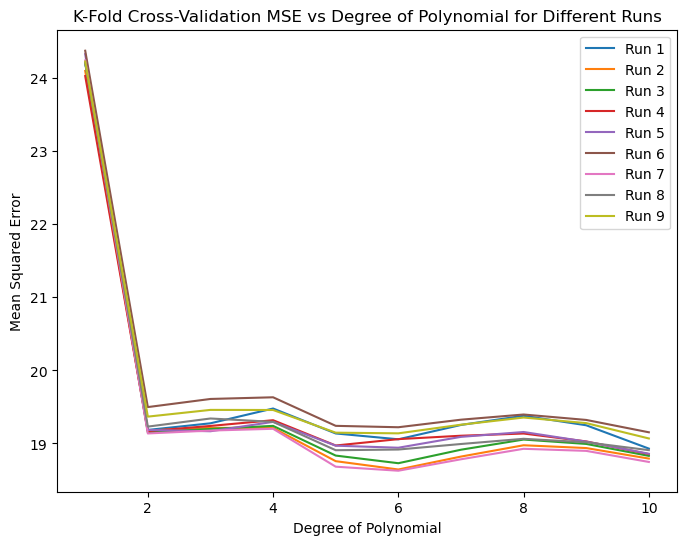

In [36]:
degrees = np.arange(1, degree_range + 1)
plt.figure(figsize=(8, 6))
for i in range(num_runs):
    plt.plot(degrees, cv_errors[:, i], label=f'Run {i+1}')

plt.xlabel("Degree of Polynomial")
plt.ylabel("Mean Squared Error")
plt.title("K-Fold Cross-Validation MSE vs Degree of Polynomial for Different Runs")
plt.legend()
plt.show()

### 3.3. The Validation Set Approach

We calculate the Mean Squared Error (MSE) for polynomial models using the Validation Set approach. This process differs from the previous K-Fold method primarily in its cross-validation setup. Here, we employ the ``ShuffleSplit`` function, creating a single split defined by a test_size that is half the size of the dataset. This setup randomly partitions the dataset into a training set and a validation set for each run, ensuring a distinct and randomized division each time. The ``cross_validate`` function is then used to compute the MSE for polynomial degrees ranging from 1 to 5. T

In [37]:
cv_error = np.zeros(5)
test_size = int(len(X)/2)

In [43]:
validation = ShuffleSplit(n_splits=1,
                            test_size=test_size,
                            random_state=0)

In [44]:
H = np.array(auto['horsepower'])
M = LinearRegression()
for i, d in enumerate(range(1,6)):
    X = np.power.outer(H, np.arange(d+1))
    M_CV = cross_validate(M,
                          X, 
                          Y,
                          cv = validation,
                          scoring = 'neg_mean_squared_error')
    cv_error[i] = abs(np.mean(M_CV['test_score']))
cv_error

array([23.61661707, 18.76303135, 18.79694163, 18.77852784, 18.44908773])

We evealuate the performance of polynomial regression models using the Validation Set approach across multiple runs.

In [45]:
Y = auto['mpg']

# Number of runs and polynomial degree range
num_runs = 9
degree_range = 10
test_size = int(len(auto)/2) 

# Initialize the array to store cross-validation errors
cv_errors = np.zeros((degree_range, num_runs))
for i in range(num_runs):
    validation = ShuffleSplit(n_splits=1, test_size=test_size, random_state=i)
    H = np.array(auto['horsepower'])

    for j, d in enumerate(range(1, degree_range + 1)):
        poly = PolynomialFeatures(degree=d)
        X_poly = poly.fit_transform(H.reshape(-1, 1))
        
        M_CV = cross_validate(LinearRegression(), X_poly, Y, cv=validation, scoring='neg_mean_squared_error')
        cv_errors[j, i] = abs(np.mean(M_CV['test_score']))

# Convert to Pandas DataFrame
cv_errors_df = pd.DataFrame(cv_errors, 
                            index=[f'Degree {d + 1}' for d in range(degree_range)],
                            columns=[f'Run {i + 1}' for i in range(num_runs)])

cv_errors_df

,Run 1,Run 2,Run 3,Run 4,Run 5,Run 6,Run 7,Run 8,Run 9
Degree 1,23.616617,24.802121,23.442644,20.755408,25.313382,29.588635,24.096798,25.467909,22.712540
Degree 2,18.763031,18.848293,18.550199,16.945107,20.644036,24.147272,18.385200,20.010937,16.301632
Degree 3,18.796942,18.805111,18.595222,16.974378,20.701120,24.098926,18.661293,19.958963,16.929114
Degree 4,18.778528,18.711722,18.592745,16.895892,20.646031,24.202113,18.710618,20.067914,17.128268
Degree 5,18.449088,18.324144,18.308049,16.736968,20.032196,23.483785,18.004158,19.921741,17.401478
Degree 6,18.190992,18.259286,18.610346,16.855047,20.669682,23.284975,17.881676,20.420654,18.534782
Degree 7,18.405163,18.293107,18.525647,17.207187,20.017687,23.537066,18.097072,20.155157,18.018994
Degree 8,18.593393,18.415016,18.433729,17.362045,20.139837,23.769550,18.241329,19.962407,17.287534
Degree 9,18.628843,18.464852,18.295298,17.199380,20.177804,23.766732,18.131042,19.729789,16.639817
Degree 10,18.532708,18.370592,18.264668,16.920118,20.012672,23.579610,17.846697,19.609816,16.303545


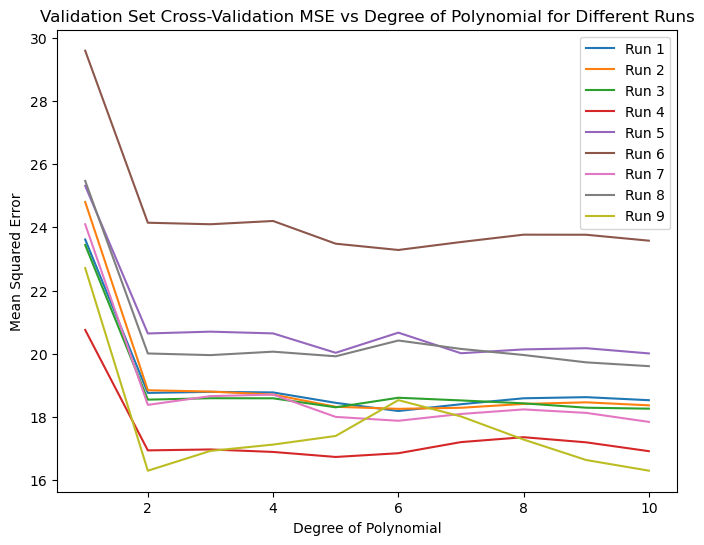

In [46]:
degrees = np.arange(1, degree_range + 1)
plt.figure(figsize=(8, 6))
for i in range(num_runs):
    plt.plot(degrees, cv_errors[:, i], label=f'Run {i+1}')

plt.xlabel("Degree of Polynomial")
plt.ylabel("Mean Squared Error")
plt.title("Validation Set Cross-Validation MSE vs Degree of Polynomial for Different Runs")
plt.legend()
plt.show()